In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset, get_dataset_config_names

In [2]:
parquet_path = './wikimap.parquet'
if not os.path.exists(parquet_path):
    np_positions = np.load('./low_d.npy')
    coords = pd.DataFrame(np_positions, columns=['x', 'y'])

    subsets = sorted(get_dataset_config_names("wikimedia/wikipedia"))

    df_list = []
    for i, subset in tqdm(enumerate(subsets), desc="Loading subsets"):
        ds = load_dataset("wikimedia/wikipedia", subset)
        df_list.append(pd.DataFrame({
            'title': ds['train']['title'],
            'subset': subset,
            'url': ds['train']['url'],
            'wid': ds['train']['id']
        }))
    meta = pd.concat(df_list, ignore_index=True)
    # Combine the metadata with coordinates
    data = pd.concat([coords, meta], axis=1)

    data.to_parquet(parquet_path)
else:
    print(f"File already exists at {parquet_path}")



File already exists at ./wikimap.parquet


In [3]:
# Load the data from the parquet file
data = pd.read_parquet(parquet_path)

In [4]:
data.head()

,x,y,title,subset,url,wid
0,-74.382103,259.878510,Аԥсуа бызшәа,20231101.ab,https://ab.wikipedia.org/wiki/%D0%90%D4%A5%D1%...,807
1,-74.580994,259.981293,Аҟәа,20231101.ab,https://ab.wikipedia.org/wiki/%D0%90%D2%9F%D3%...,1040
2,-270.739716,486.283691,Аԥсуа алфавит,20231101.ab,https://ab.wikipedia.org/wiki/%D0%90%D4%A5%D1%...,1044
3,-74.554779,259.965332,Гагра,20231101.ab,https://ab.wikipedia.org/wiki/%D0%93%D0%B0%D0%...,1046
4,-74.614174,259.980438,Аԥсны Аҳәынҭқарра,20231101.ab,https://ab.wikipedia.org/wiki/%D0%90%D4%A5%D1%...,1053


In [5]:
# Filter the data to include only English ('en') and Russian ('ru') subsets
en_ru_data = data[data['subset'].isin(['20231101.en', '20231101.ru'])].copy()

# Display information about the filtered dataframe
print(f"Original dataframe shape: {data.shape}")
print(f"English and Russian dataframe shape: {en_ru_data.shape}")
en_ru_data.head()


Original dataframe shape: (61614907, 6)
English and Russian dataframe shape: (8352877, 6)


,x,y,title,subset,url,wid
16757956,-7.487186,-135.301636,Anarchism,20231101.en,https://en.wikipedia.org/wiki/Anarchism,12
16757957,10.143961,-209.311813,Albedo,20231101.en,https://en.wikipedia.org/wiki/Albedo,39
16757958,-63.998100,-41.360218,A,20231101.en,https://en.wikipedia.org/wiki/A,290
16757959,54.339321,-328.290894,Alabama,20231101.en,https://en.wikipedia.org/wiki/Alabama,303
16757960,22.358633,287.458069,Achilles,20231101.en,https://en.wikipedia.org/wiki/Achilles,305


In [6]:
# Import necessary libraries for decision tree classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Extract features (x, y coordinates) and target (subset)
X = en_ru_data[['x', 'y']]
y = en_ru_data['subset']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

depths = [2, 4, 8, 16, 32]
trees = []
train_accuracies = []
test_accuracies = []

for d in depths:
    # Create and train the decision tree classifier
    dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=d, min_samples_leaf=10)
    
    # Fit the model on the training data
    dt_classifier.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = dt_classifier.predict(X_test)
    
    # Evaluate the model on test data
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(test_accuracy)
    
    # Get training accuracy
    y_train_pred = dt_classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    print(f"Decision Tree Depth {d} - Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    trees.append(dt_classifier)

Decision Tree Depth 2 - Train Accuracy: 0.7833, Test Accuracy: 0.7828
Decision Tree Depth 4 - Train Accuracy: 0.7926, Test Accuracy: 0.7922
Decision Tree Depth 8 - Train Accuracy: 0.8091, Test Accuracy: 0.8086
Decision Tree Depth 16 - Train Accuracy: 0.8533, Test Accuracy: 0.8472
Decision Tree Depth 32 - Train Accuracy: 0.8956, Test Accuracy: 0.8572


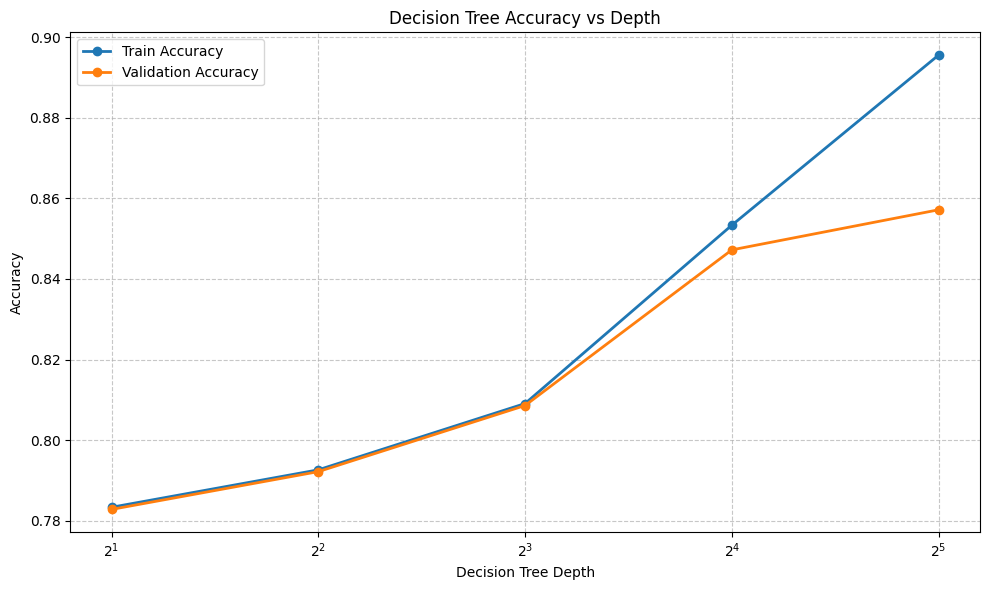

In [7]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot depth vs accuracy with log scale on x-axis only
plt.plot(depths, train_accuracies, marker='o', linestyle='-', linewidth=2, label='Train Accuracy')
plt.plot(depths, test_accuracies, marker='o', linestyle='-', linewidth=2, label='Validation Accuracy')
# Set x-axis to log2 scale, keep y-axis linear
plt.xscale('log', base=2)
# plt.yscale('log')  # Removed log scale for y-axis

# Add labels and title
plt.xlabel('Decision Tree Depth')
plt.ylabel('Accuracy')  # Updated to reflect linear scale
plt.title('Decision Tree Accuracy vs Depth')  # Updated title

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Improve the appearance
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=16, min_samples_leaf=10)
    
# Fit the model on the training data
dt_classifier.fit(X, y)


DecisionTreeClassifier(max_depth=16, min_samples_leaf=10, random_state=42)

/Users/brandon/root/refik/env/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


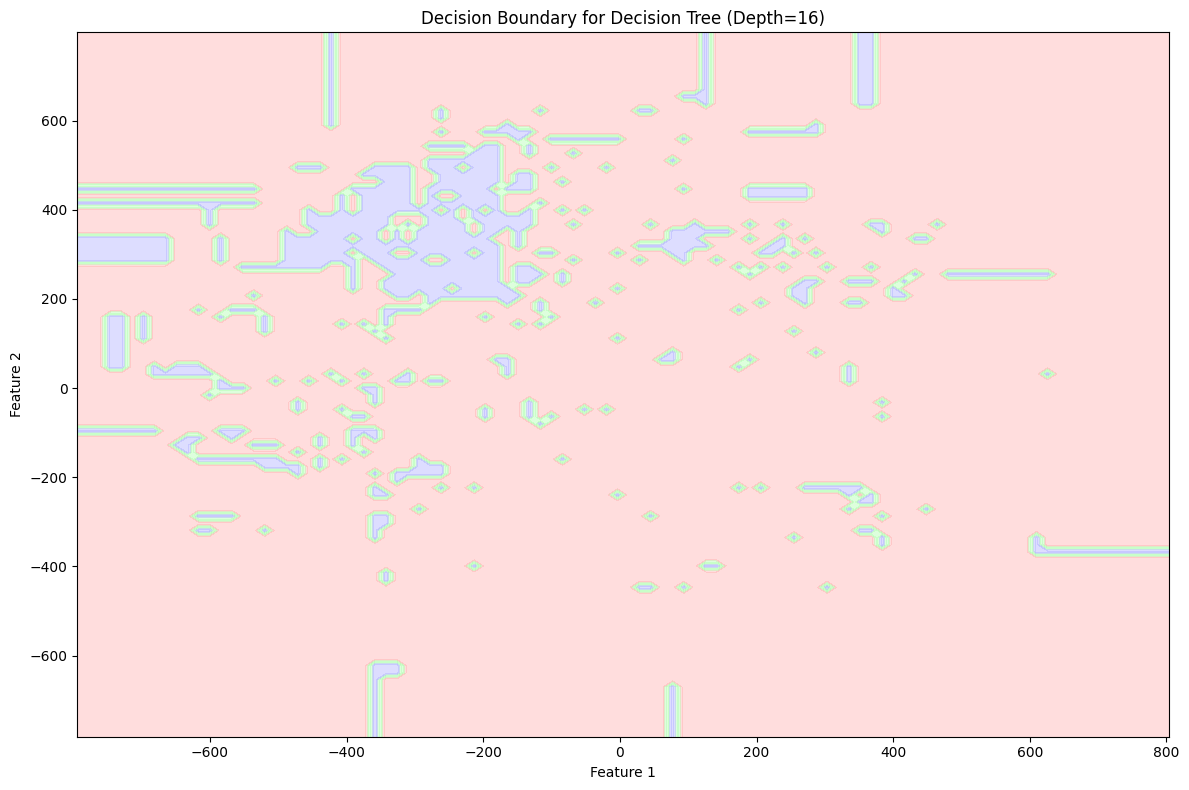

In [9]:
# Visualize the decision boundary of the depth 8 tree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

depth_16_tree = dt_classifier

# Create a mesh grid to visualize the decision boundary
# Define the boundaries for the mesh grid
# Using linear space with 100 samples on each axis
x_min, x_max = en_ru_data['x'].min() - 1, en_ru_data['x'].max() + 1
y_min, y_max = en_ru_data['y'].min() - 1, en_ru_data['y'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict the class for each point in the mesh grid
Z = depth_16_tree.predict(np.c_[xx.ravel(), yy.ravel()])
to_int = {'20231101.en': 0, '20231101.ru': 1}
Z = [to_int[z] for z in Z]
Z = np.array(Z).reshape(xx.shape)

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Plot the decision boundary
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)

plt.title(f'Decision Boundary for Decision Tree (Depth=16)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.tight_layout()
plt.show()


In [10]:
# Create a histogram of the percentage of English articles in each leaf node
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Get the leaf node indices
leaf_nodes = depth_16_tree.apply(en_ru_data[['x', 'y']].values)
unique_leaf_nodes = np.unique(leaf_nodes)

print(f"Number of leaf nodes in depth 16 tree: {len(unique_leaf_nodes)}")

# Calculate percentage of English articles in each leaf node
english_percentages = []
node_sizes = []

for node_id in unique_leaf_nodes:
    # Get samples in this leaf node
    node_samples_indices = np.where(leaf_nodes == node_id)[0]
    node_samples = en_ru_data.iloc[node_samples_indices]
    
    # Count languages in this node
    language_counts = Counter(node_samples['subset'])
    total_samples = len(node_samples)
    
    # Skip nodes with very few samples
    if total_samples < 5:
        continue
    
    # Calculate percentage of English articles
    english_count = language_counts.get('20231101.en', 0)
    english_percentage = (english_count / total_samples) * 100
    
    english_percentages.append(english_percentage)
    node_sizes.append(total_samples)



/Users/brandon/root/refik/env/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Number of leaf nodes in depth 16 tree: 23770


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


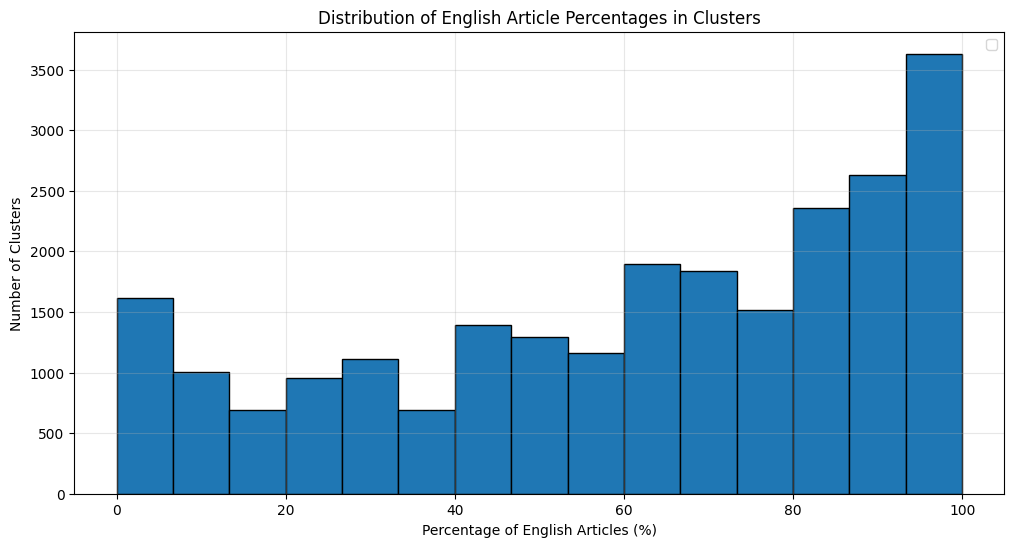

Total leaf nodes analyzed: 23770
Average percentage of English articles: 60.88%
Median percentage of English articles: 67.65%
Number of predominantly English nodes (>50%): 15335
Number of predominantly Russian nodes (<50%): 7693


In [11]:
# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(english_percentages, bins=15, edgecolor='black')
plt.title('Distribution of English Article Percentages in Clusters')
plt.xlabel('Percentage of English Articles (%)')
plt.ylabel('Number of Clusters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print(f"Total leaf nodes analyzed: {len(english_percentages)}")
print(f"Average percentage of English articles: {np.mean(english_percentages):.2f}%")
print(f"Median percentage of English articles: {np.median(english_percentages):.2f}%")
print(f"Number of predominantly English nodes (>50%): {sum(p > 50 for p in english_percentages)}")
print(f"Number of predominantly Russian nodes (<50%): {sum(p < 50 for p in english_percentages)}")


In [12]:
# Calculate entropy of language distribution in each leaf node
entropies = []

for node_id in unique_leaf_nodes:
    # Get samples in this leaf node
    node_samples_indices = np.where(leaf_nodes == node_id)[0]
    node_samples = en_ru_data.iloc[node_samples_indices]
    
    # Skip nodes with very few samples
    if len(node_samples) < 5:
        continue
    
    # Count languages in this node
    language_counts = Counter(node_samples['subset'])
    total_samples = len(node_samples)
    
    # Calculate probability for each language
    probabilities = [count/total_samples for count in language_counts.values()]
    
    # Calculate entropy: -sum(p * log2(p))
    entropy = -sum(p * np.log2(p) for p in probabilities)
    entropies.append(entropy)



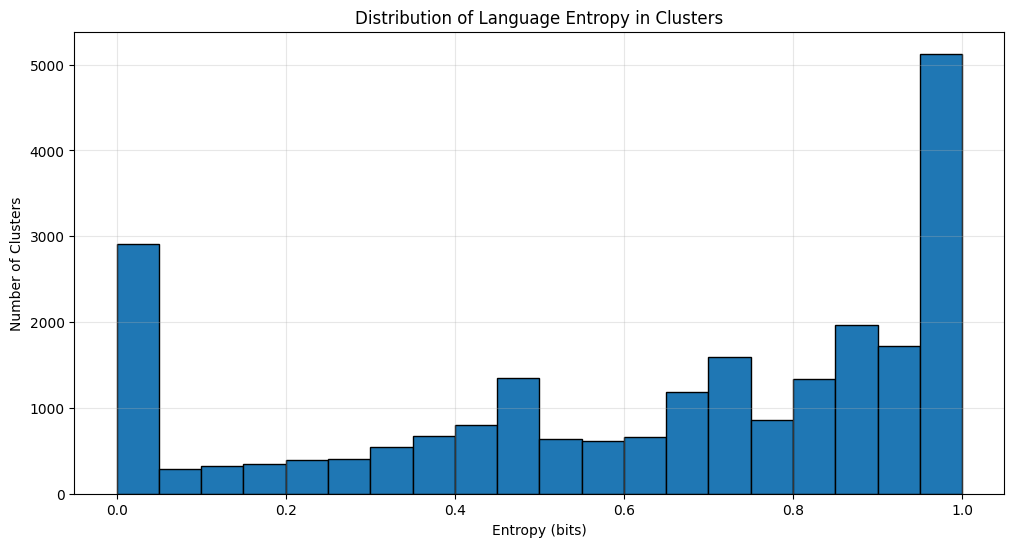

Total leaf nodes analyzed: 23770
Average entropy: 0.63 bits
Median entropy: 0.72 bits
Max entropy: 1.00 bits
Min entropy: -0.00 bits


In [13]:
# Create histogram of entropies
plt.figure(figsize=(12, 6))
plt.hist(entropies, bins=20, edgecolor='black')
plt.title('Distribution of Language Entropy in Clusters')
plt.xlabel('Entropy (bits)')
plt.ylabel('Number of Clusters')
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print(f"Total leaf nodes analyzed: {len(entropies)}")
print(f"Average entropy: {np.mean(entropies):.2f} bits")
print(f"Median entropy: {np.median(entropies):.2f} bits")
print(f"Max entropy: {np.max(entropies):.2f} bits")
print(f"Min entropy: {np.min(entropies):.2f} bits")


In [14]:
pure_leaf_nodes = []
for node_id, entropy in zip(unique_leaf_nodes, entropies):
    if entropy == 0:
        pure_leaf_nodes.append(node_id)

In [22]:
# Print samples from the largest leaf nodes
# Set random seed for reproducibility
np.random.seed(420)
pure_leaf_node_sample = np.random.choice(pure_leaf_nodes, 3, replace=False)

for node_id in pure_leaf_node_sample:
    # Get samples in this leaf node
    node_samples_indices = np.where(leaf_nodes == node_id)[0]
    node_samples = en_ru_data.iloc[node_samples_indices]
    
    # Print information about this node
    print(f"Cluster: {node_id}, Size {len(node_samples)}, Entropy: {entropies[np.where(unique_leaf_nodes == node_id)[0][0]]:.2f} bits")
    print("Sample articles:")
    
    # Display 10 random articles from this node
    for _, article in node_samples.sample(10).iterrows():
        print(f"  {article['title']}")
    print('\n')
    print("-" * 80)


Cluster: 34853, Size 50, Entropy: -0.00 bits
Sample articles:
  Amara exarata
  Amara fusca
  Amara familiaris
  Amara alpina
  Amara praetermissa
  Amara confusa
  Amara quenseli
  Amara pomona
  Amara latior
  Amara rubrica


--------------------------------------------------------------------------------
Cluster: 29172, Size 18, Entropy: -0.00 bits
Sample articles:
  Hencse
  Kálmáncsa
  Fonyód District
  Nagyberény
  Szentbalázs
  Gamás
  Öreglak
  Bélavár
  Marcali
  Nagykorpád


--------------------------------------------------------------------------------
Cluster: 40931, Size 50, Entropy: -0.00 bits
Sample articles:
  Codex Bezae
  Codex Vaticanus 2061
  Codex Marchalianus
  Codex Speculum
  Codex Brixianus
  Codex Toletanus
  Codex Sangallensis 1395
  Codex Vaticanus Ottobonianus Latinus 1829
  Codex Agobardinus
  Codex Boernerianus


--------------------------------------------------------------------------------
